In [ ]:
!pip install pyDOE

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import imageio
import os
# from google.colab import files
from pyDOE import lhs


2025-04-09 20:01:03.625321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 20:01:03.638588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744237863.653429 3706983 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744237863.657924 3706983 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 20:01:03.673748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# Boundaries of the computational domain
xleft, xright = -4000, 4000
ylower, yupper = -4000, 4000

t0, tfinal = 0, 1228.46

# Gravitational constant
g = 9.81

### Subclassing layers

In [ ]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return (inputs-self.xmin)/(self.xmax-self.xmin)

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [ ]:
# Oscillating flow in 2D parabolic basin (Thacker, 1981)
D0 = 3.0
Z0 = 1.0
L = 3000
omega = tf.sqrt(8*g*D0)/L

delta = 0.0

U = 1.0
H = 1.0
T = tfinal

t0 = 0.0

A = tf.constant(((D0 + Z0)**2 - D0**2)/((D0 + Z0)**2 + D0**2), tf.float32)

# Initial conditions
hh0 = lambda x, y: D0*(tf.sqrt(1-A**2)/(1-A*tf.cos(omega*t0)) - 1 - (x**2+y**2)/L**2*((1-A**2)/(1-A*tf.cos(omega*t0))**2-1)  )
z0 = lambda x, y: D0*((x**2+y**2)/L**2 -1)
uu0 = lambda x, y: omega*A*tf.sin(omega*t0)/(1-A*tf.cos(omega*t0))*x/2
vv0 = lambda x, y: omega*A*tf.sin(omega*t0)/(1-A*tf.cos(omega*t0))*y/2

h0 = lambda x, y: tf.math.maximum(hh0(x, y), z0(x, y)+delta) - z0(x,y)
u0 = lambda x, y: uu0(x, y)
v0 = lambda x, y: vv0(x, y)

hh_analytic = lambda t, x, y: D0*(tf.sqrt(1-A**2)/(1-A*tf.cos(omega*t)) - 1 - (x**2+y**2)/L**2*((1-A**2)/(1-A*tf.cos(omega*t))**2-1)  )
h_analytic = lambda t, x, y: tf.math.maximum(hh_analytic(t, x, y), z0(x, y)+delta) - z0(x,y)

I0000 00:00:1744237865.936621 3706983 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47184 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
I0000 00:00:1744237865.937904 3706983 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47184 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


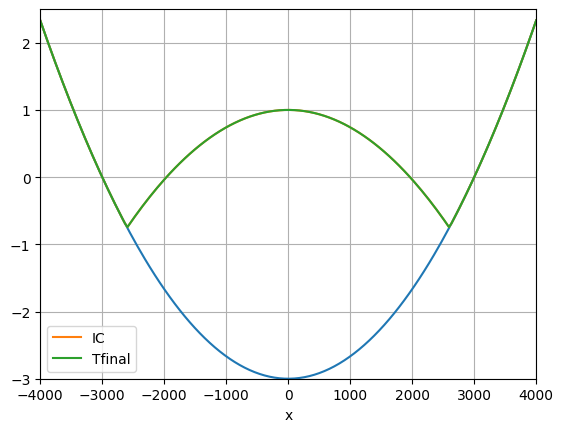

In [ ]:
x = np.linspace(xleft, xright, 200).astype(np.float32)
y = np.linspace(ylower, yupper, 200).astype(np.float32)

xx, yy = np.meshgrid(x, y, indexing='ij')

z0c = z0(xx, yy)
h0c = h0(xx, yy)
h_0 = h_analytic(tfinal, xx, yy)

p = 100
plt.plot(x, z0c[:,p])
plt.plot(x, h0c[:,p] + z0c[:,p], label='IC')
plt.plot(x, h_0[:,p] + z0c[:,p], label='Tfinal')

plt.xlabel('x')
plt.axis([-4000, 4000, -3, 2.5])
plt.grid()
plt.legend()

In [ ]:
def build_model(t0, tfinal, n_units=60, n_layers=4):

  # Define the network
  inp1 = tf.keras.layers.Input(shape=(1,))
  b1 = Normalize(t0, tfinal)(inp1)

  inp2 = tf.keras.layers.Input(shape=(1,))
  b2 = Normalize(xleft, xright)(inp2)

  inp3 = tf.keras.layers.Input(shape=(1,))
  b3 = Normalize(ylower, yupper)(inp3)

  b = tf.keras.layers.Concatenate()([b1, b2, b3])

  for i in range(n_layers):
    b = tf.keras.layers.Dense(n_units, activation='tanh')(b)

  u = tf.keras.layers.Dense(1, activation='linear')(b)
  v = tf.keras.layers.Dense(1, activation='linear')(b)
  h = tf.keras.layers.Dense(1, activation='linear')(b)

  model = tf.keras.models.Model([inp1, inp2, inp3], [u, v, h])

  return model

In [ ]:
model = build_model(t0, tfinal)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_1         │ (None, 1)         │          0 │ input_layer[0][0] │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_3         │ (None, 1)         │          0 │ input_layer_1[0]… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_5         │ (None, 1)         │          0 │ input_layer_2[0]… │
│ (Normalize)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ normalize_1[0][0… │
│ (Concatenate)       │                   │            │ normalize_3[0][0… │
│                     │                   │            │ normalize_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60)        │        240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60)        │      3,660 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 60)        │      3,660 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 60)        │      3,660 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         61 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         61 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         61 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,403 (44.54 KB)

 Trainable params: 11,403 (44.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def defineCollocationPoints(t_bdry, x_bdry, y_bdry, N_pde=10000, N_ic=10):

  # Convert input to numpy array
  t_bdry, x_bdry = np.array(t_bdry), np.array(x_bdry)

  # Uniform random sampling for PDE points
  tx_min = np.array([t_bdry[0], x_bdry[0], y_bdry[0]])
  tx_max = np.array([t_bdry[1], x_bdry[1], y_bdry[1]])
  pde_points = tx_min + (tx_max - tx_min)*lhs(3, N_pde)
  t_pde = pde_points[:, 0]
  x_pde = pde_points[:, 1]
  y_pde = pde_points[:, 2]

  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde, y_pde]).astype(np.float32)

  # Sample points where to evaluate the initial values
  init_points = tx_min[1:] + (tx_max[1:] - tx_min[1:])*lhs(2, N_ic)
  x_init = init_points[:,0]
  y_init = init_points[:,1]
  t_init = t_bdry[0]+ 0.0*x_init
  u_init = u0(x_init, y_init)
  v_init = v0(x_init, y_init)
  h_init = h0(x_init, y_init)
  inits = np.column_stack([t_init, x_init, y_init, u_init, v_init, h_init]).astype(np.float32)

  return pdes, inits

In [ ]:
N_pde = 200000
N_inits = 20000
pdes, inits = defineCollocationPoints([t0, tfinal], [xleft, xright], [ylower, yupper],
                                      N_pde, N_inits)

In [ ]:
@tf.function
def trainStep(pdes, ics, model):

  t, x, y = pdes[:,:1], pdes[:,1:2], pdes[:,2:]
  ti, xi, yi, ui, vi, hi = ics[:,:1], ics[:,1:2], ics[:,2:3], ics[:,3:4], ics[:,4:5], ics[:,5:6]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(t), tape1.watch(x), tape1.watch(y)
      [u, v, h] = model([t, x, y])
      # h = tf.where(h > delta, h, 0)
      z = z0(x, y)

      # Fluxes
      f1, f2, f3 = h*u, h*u**2 + g*h**2/2, h*u*v
      g1, g2, g3 = h*v, h*u*v, h*v**2 + g*h**2/2

    # Required derivatives
    [hut, f1x] = tape1.gradient(f1, [t, x])
    f2x = tape1.gradient(f2, x)
    f3x = tape1.gradient(f3, x)

    [hvt, g1y] = tape1.gradient(g1, [t, y])
    g2y = tape1.gradient(g2, y)
    g3y = tape1.gradient(g3, y)

    ht = tape1.gradient(h, t)
    [zx, zy] = tape1.gradient(z, [x, y])

    # Solve the shallow-water equations
    eqn1 = ht + f1x + g1y
    eqn2 = hut + f2x + g2y + g*h*zx
    eqn3 = hvt + f3x + g3y + g*h*zy

    # Define the PDE loss
    PDEloss = tf.reduce_mean((T/H*eqn1)**2 + (T/(H*U)*eqn2)**2 + (T/(H*U)*eqn3)**2)

    # Initial value loss
    [ui_pred, vi_pred, hi_pred] = model([ti, xi, yi])
    ICloss = tf.reduce_mean((ui*hi-ui_pred*hi_pred)**2/(H*U)**2 + (vi*hi-vi_pred*hi_pred)**2/(H*U)**2 + (hi-hi_pred)**2/H**2)

    loss = PDEloss + ICloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return loss, grads

In [ ]:
def PINNtrain(pde_points, ic_points, epochs=1000):

  # Optimizer for the problem
  lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-4, decay_steps=epochs,
                                                     end_learning_rate=1e-4)
  opt = tf.keras.optimizers.Adam(lr)

  # Number of collocation points
  nr_pde_points = len(pde_points)
  nr_ic_points = len(ic_points)

# Batch sizes
  batch_factor = 20
  bs_pde = nr_pde_points//(batch_factor)
  bs_ics = nr_ic_points//(batch_factor)

  # Epoch loss initialization
  epoch_loss = np.zeros(epochs)

  # tf dataset for collocation points
  ds_pde = tf.data.Dataset.from_tensor_slices(pde_points)
  ds_pde = ds_pde.shuffle(nr_pde_points).batch(bs_pde)

  ds_init = tf.data.Dataset.from_tensor_slices(ic_points)
  ds_init = ds_init.cache().shuffle(nr_ic_points).batch(bs_ics)

  # Combine the datasets
  ds = tf.data.Dataset.zip((ds_pde, ds_init))

  # Main training loop
  for i in range(epochs):

    nr_batches = 0

    # Train the model
    for (pdes, ics) in ds:

      # Train the network
      loss, grads = trainStep(pdes, ics, model)

      # Gradient step
      opt.apply_gradients(zip(grads, model.trainable_variables))

      epoch_loss[i] += loss
      nr_batches += 1

    epoch_loss[i] /= nr_batches

    if (np.mod(i, 100)==0):
      print(f"Total loss in {i}th epoch: {epoch_loss[i]: 2.6f}")

  return epoch_loss

In [ ]:
epochs = 20000
loss = PINNtrain(pdes, inits, epochs)

Total loss in 0th epoch:  0.009258
Total loss in 100th epoch:  0.000176
Total loss in 200th epoch:  0.000211
Total loss in 300th epoch:  0.000197
Total loss in 400th epoch:  0.000203
Total loss in 500th epoch:  0.000192
Total loss in 600th epoch:  0.000196
Total loss in 700th epoch:  0.000185
Total loss in 800th epoch:  0.000207
Total loss in 900th epoch:  0.000212
Total loss in 1000th epoch:  0.000170
Total loss in 1100th epoch:  0.000197
Total loss in 1200th epoch:  0.000213
Total loss in 1300th epoch:  0.000245
Total loss in 1400th epoch:  0.000225
Total loss in 1500th epoch:  0.000197
Total loss in 1600th epoch:  0.000214
Total loss in 1700th epoch:  0.000166
Total loss in 1800th epoch:  0.000188
Total loss in 1900th epoch:  0.000182
Total loss in 2000th epoch:  0.000210
Total loss in 2100th epoch:  0.000202
Total loss in 2200th epoch:  0.000231
Total loss in 2300th epoch:  0.000168
Total loss in 2400th epoch:  0.000170
Total loss in 2500th epoch:  0.000175
Total loss in 2600th epo

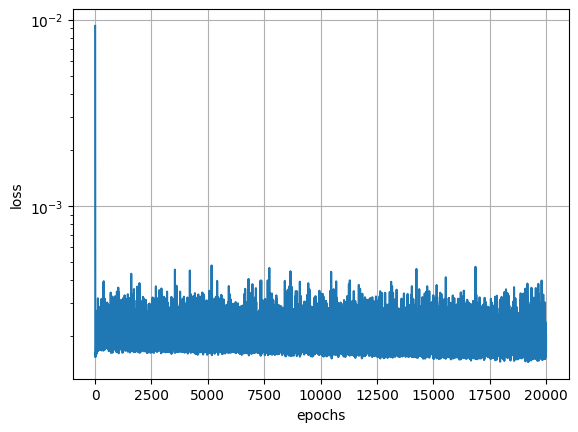

In [ ]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.grid()

In [ ]:
# Grid where to evaluate the model
l, m = 500, 100

t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
y = np.linspace(ylower, yupper, m)

TT, XX, YY = np.meshgrid(t, x, y, indexing='ij')

# Evaluate the model
[u, v, h] = model([np.expand_dims(TT.flatten(), axis=1),
                   np.expand_dims(XX.flatten(), axis=1),
                   np.expand_dims(YY.flatten(), axis=1)])

u = np.reshape(u, (l, m, m))
v = np.reshape(v, (l, m, m))
h = np.reshape(h, (l, m, m))
b = np.reshape(z0(XX.flatten(),YY.flatten()), (l, m, m))

Text(0, 0.5, 'h+b')

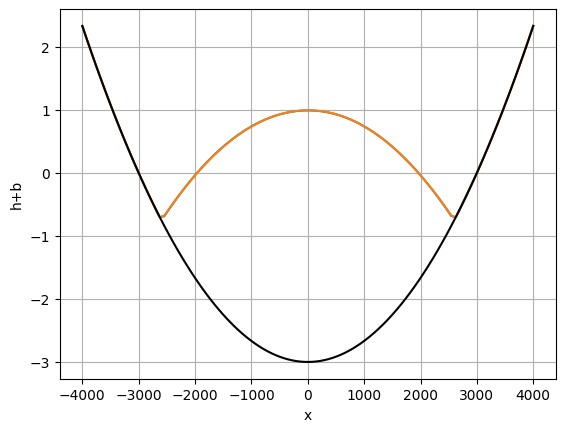

In [ ]:
# plt.subplot(133)
p = m//2

step = 0
plt.plot(x, h[step,:,p]+b[step,:,p])

step = -1
plt.plot(x, h[step,:,p]+b[step,:,p])
plt.plot(x, b[step,:,p], 'k')
plt.grid()
plt.xlabel('x')
plt.ylabel('h+b')

In [ ]:
htrue = h_analytic(TT, XX, YY)

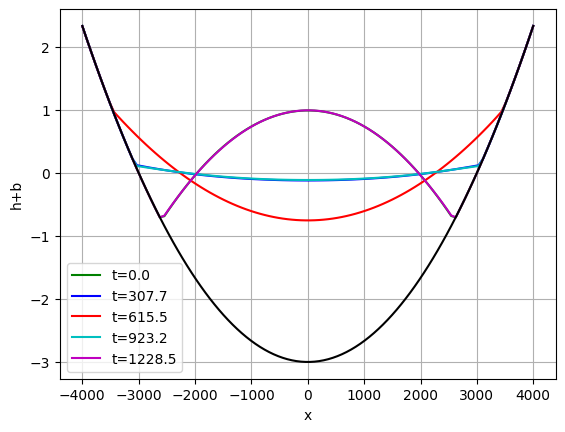

In [ ]:
p = m//2

nr = 5
steps = [i*len(h)//(nr-1) for i in range(nr)]
steps[-1] = -1
colors = ['g','b','r','c','m','y']

for c, step in zip(colors,steps):
  # step = steps[i]
  plt.plot(x, h[step,:,p]+b[step,:,p], color=c, label=f't={t[step]:.1f}')
plt.plot(x, b[step,:,p], 'k')
plt.grid()

plt.xlabel('x')
plt.ylabel('h+b')
plt.legend()

In [ ]:
print(steps)
print(t[steps])

[0, 125, 250, 375, -1]
[   0.          307.73046092  615.46092184  923.19138277 1228.46      ]


In [ ]:
2*np.pi/omega/2

<tf.Tensor: shape=(), dtype=float32, numpy=614.22998046875>

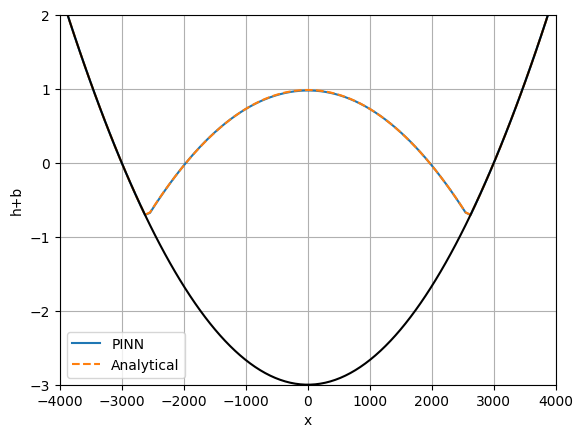

In [ ]:
step = 10
plt.plot(x, h[step,:,p]+b[step,:,p], label='PINN')
plt.plot(x, htrue[step,:,p]+b[step,:,p], '--', label='Analytical')

plt.plot(x, b[step,:,p],'k')
plt.axis([xleft, xright, -3, 2])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')
plt.savefig(f'Step{step}Bowl2D.png')

In [ ]:
err = np.linalg.norm(h-htrue, ord=2, axis=(1,2))/np.linalg.norm(htrue+b, ord=2, axis=(1,2))

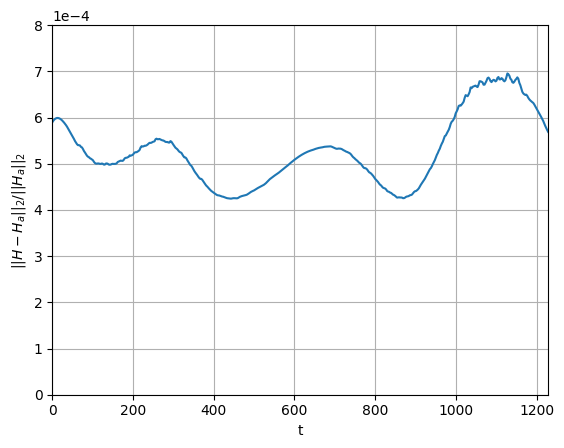

In [ ]:
fig, ax = plt.subplots()

plt.plot(t, err)
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$||H-H_a||_2/||H_a||_2$')
ax.set_xlim(0.0, tfinal)
ax.set_ylim(0.0, 0.0008)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('errorBowlTimeSeries2D.png', dpi=300, bbox_inches='tight')

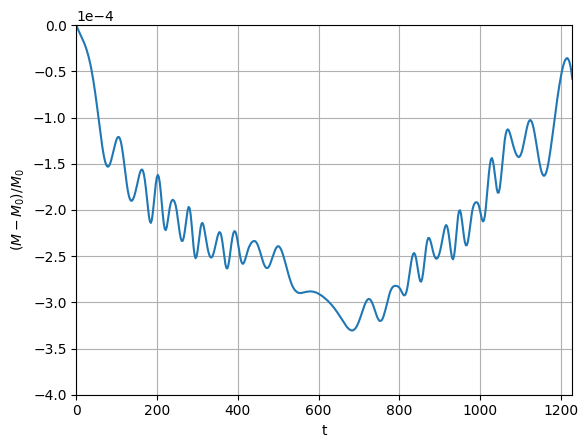

In [ ]:
fig, ax = plt.subplots()

mass = np.sum(h, axis=(1,2))

plt.plot(t, (mass-mass[0])/mass[0])
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$(M-M_0)/M_0$')
ax.set_xlim(0.0, tfinal)
ax.set_ylim(-0.0004, 0.000)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('massTimeSeriesBowl2D.png')

Text(0, 0.5, 'error')

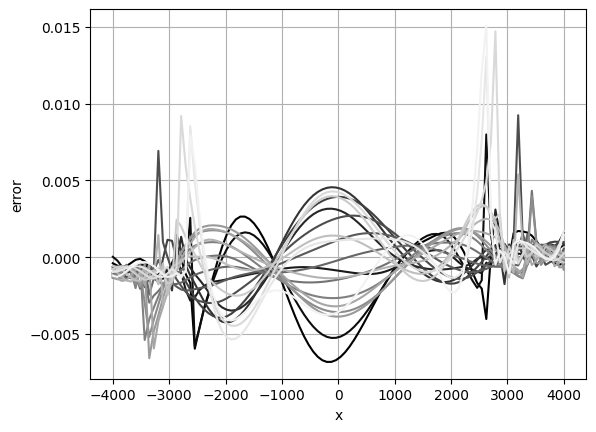

In [ ]:
steps = 20
for i in range(steps):
  step = i*h.shape[0]//steps
  plt.plot(x, (h[step,:,p]-htrue[step,:,p]), color=[i/steps,i/steps,i/steps])
plt.grid()
plt.xlabel('x')
plt.ylabel('error')

In [ ]:
model.save('BowlModel.keras')
np.save('hBowl2D.npy', h)
np.save('uBowl2D.npy', u)